In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mumbai-tweets/finalmumbai-1.csv
/kaggle/input/roberta-weights/model.h5


In [2]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

2022-02-14 12:20:14.177013: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-14 12:20:14.177137: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

2022-02-14 12:20:19.374858: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-14 12:20:19.378023: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-14 12:20:19.378060: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-14 12:20:19.378094: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (df68ec0af7bc): /proc/driver/nvidia/version does not exist
2022-02-14 12:20:19.380677: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Running on TPU  grpc://10.0.0.2:8470
Number of replicas: 8


In [4]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 35
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 2

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [5]:
df = pd.read_csv('../input/mumbai-tweets/finalmumbai-1.csv')
df = df.drop(['Unnamed: 0'],axis=1)
df = df.reset_index(drop = True)
df

,id,date,content
0,1.366151e+18,2021-02-28,posted photo prabhadevi
1,1.366148e+18,2021-02-28,shayari mumbai maharashtra shayaris shayar sha...
2,1.366146e+18,2021-02-28,last day night power cut facing turbhe sec res...
3,1.366145e+18,2021-02-28,best friend important असत सगळ
4,1.366144e+18,2021-02-28,उसक पहल हतर टमर करत टमर अपन महत करत local
...,...,...,...
599628,1.388287e+18,2021-05-01,sir case message behalf patient bed attendents...
599629,1.388287e+18,2021-05-01,thanks followgood day
599630,1.388286e+18,2021-05-01,tha nahin thi
599631,1.388285e+18,2021-05-01,hell look like


In [6]:
from datetime import datetime

def strtodate(text):
    return datetime.strptime(text, '%Y-%m-%d').date()

df['date']=df['date'].apply(strtodate)

In [7]:
df = df.sort_values(by="date")
df = df.reset_index(drop=True)
df

,id,date,content
0,1.345009e+18,2021-01-01,आरत livemay bappa bless
1,1.344989e+18,2021-01-01,entire struggle liberation ram jnmbhumi religi...
2,1.344989e+18,2021-01-01,ajun janab aahe
3,1.344989e+18,2021-01-01,jai shree ram
4,1.344989e+18,2021-01-01,bye picture midday phototeam satejshinde daily...
...,...,...,...
599628,1.410134e+18,2021-06-30,bloomsburys boutique cafe artisan bakery benga...
599629,1.410134e+18,2021-06-30,tweet read maddhirane reply kodtidhyalla ninna...
599630,1.410134e+18,2021-06-30,happy birthday tanay
599631,1.410137e+18,2021-06-30,played soo hard broke racket match hard miss


In [8]:
X_data = df[['content']].to_numpy().reshape(-1)

In [9]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [10]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [11]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [12]:
with strategy.scope():
    model = build_model(2)
    model.summary()

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 35)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [13]:
model.load_weights('../input/roberta-weights/model.h5')

In [14]:
X_train = roberta_encode(X_data, tokenizer)

In [15]:
predictions = model.predict(X_train)
print(predictions)

[[2.1205137e-02 9.7879493e-01]
 [2.6311009e-06 9.9999738e-01]
 [9.6295917e-01 3.7040774e-02]
 ...
 [9.9662149e-01 3.3784595e-03]
 [9.9938762e-01 6.1237218e-04]
 [8.0247277e-01 1.9752729e-01]]


In [16]:
classes = np.argmax(predictions, axis = 1)
print(classes)

[1 1 0 ... 0 0 0]


In [17]:
df['label']=classes
df

,id,date,content,label
0,1.345009e+18,2021-01-01,आरत livemay bappa bless,1
1,1.344989e+18,2021-01-01,entire struggle liberation ram jnmbhumi religi...,1
2,1.344989e+18,2021-01-01,ajun janab aahe,0
3,1.344989e+18,2021-01-01,jai shree ram,0
4,1.344989e+18,2021-01-01,bye picture midday phototeam satejshinde daily...,1
...,...,...,...,...
599628,1.410134e+18,2021-06-30,bloomsburys boutique cafe artisan bakery benga...,1
599629,1.410134e+18,2021-06-30,tweet read maddhirane reply kodtidhyalla ninna...,0
599630,1.410134e+18,2021-06-30,happy birthday tanay,0
599631,1.410137e+18,2021-06-30,played soo hard broke racket match hard miss,0


In [18]:
df.to_csv('Mumbai_1_updated.csv')

In [19]:
df['label'].value_counts()

1    355680
0    243953
Name: label, dtype: int64

In [20]:
x = df.groupby('date') \
       .agg({'content':'size', 'label':'mean'}) \
       .rename(columns={'content':'count','label':'PCI'}) \
       .reset_index()
print (x)

           date  count       PCI
0    2021-01-01   3305  0.573676
1    2021-01-02   3063  0.558929
2    2021-01-03   3206  0.567062
3    2021-01-04   3177  0.544539
4    2021-01-05   3245  0.554391
..          ...    ...       ...
176  2021-06-26   1638  0.510379
177  2021-06-27   1545  0.471845
178  2021-06-28   1555  0.526688
179  2021-06-29   1517  0.519446
180  2021-06-30   1554  0.492921

[181 rows x 3 columns]


In [21]:
x.to_csv('Mumbai_1_PCI.csv')

<AxesSubplot:xlabel='date'>

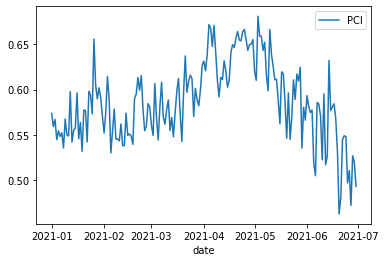

In [22]:
x.plot(x="date", y=["PCI"])